# Het verschil tussen startpositie en strategie

/tmp/ipykernel_41012/2923122759.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Pos'] = df_clean['Pos'].astype(int)
/tmp/ipykernel_41012/2923122759.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['FinPos_numeric'] = df_clean['FinPos_numeric'].astype(int)


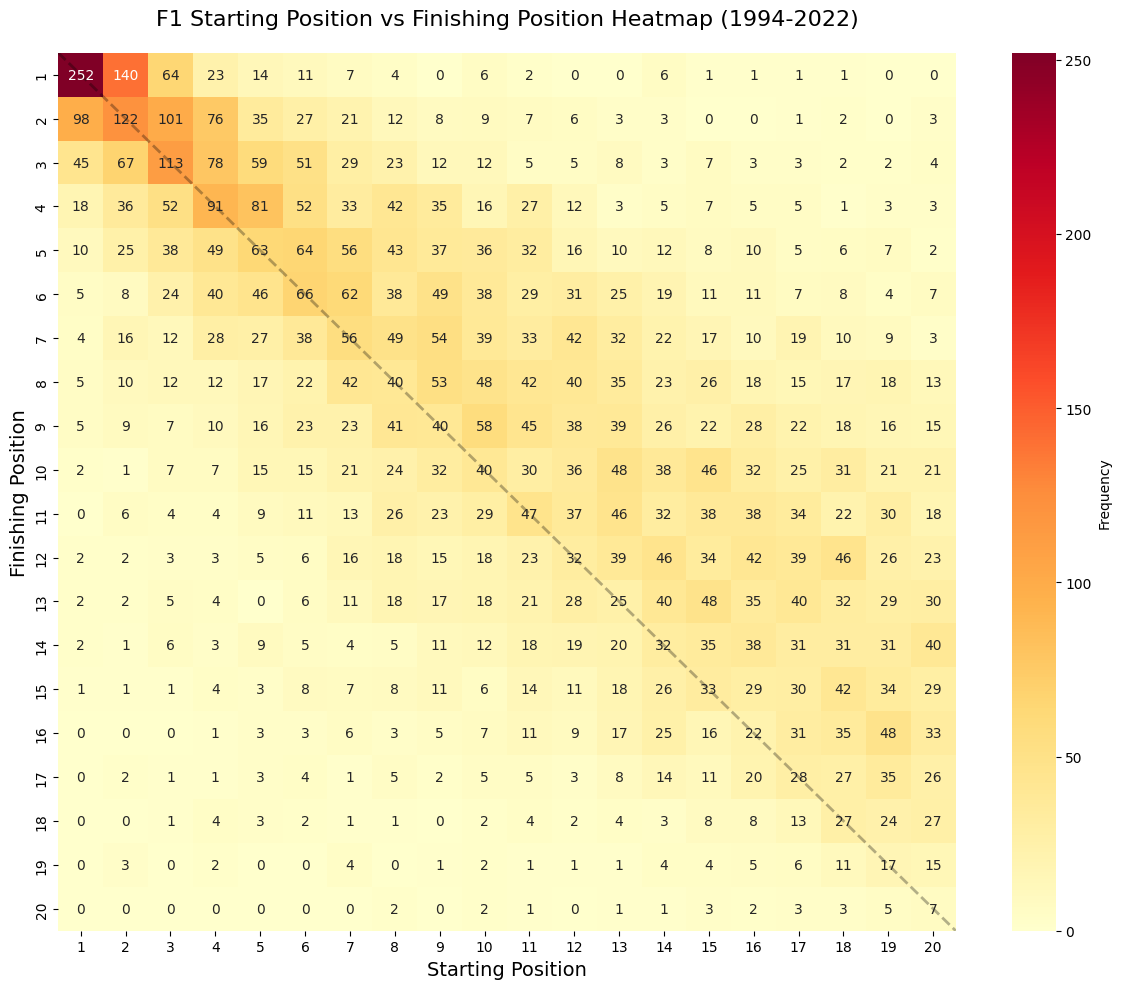

/tmp/ipykernel_41012/2923122759.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['position_change'] = df_clean['FinPos_numeric'] - df_clean['Pos']


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv('merged_f1_data_1994_2022.csv')

# Convert FinPos to numeric, treating 'NC' as NaN
df['FinPos_numeric'] = pd.to_numeric(df['FinPos'], errors='coerce')

# Filter out rows where either position is NaN
df_clean = df.dropna(subset=['Pos', 'FinPos_numeric'])

# Convert to integers
df_clean['Pos'] = df_clean['Pos'].astype(int)
df_clean['FinPos_numeric'] = df_clean['FinPos_numeric'].astype(int)

# Create a frequency matrix for the heatmap
# We'll consider positions 1-20 for better visualization
max_pos = 20
heatmap_data = np.zeros((max_pos, max_pos))

for _, row in df_clean.iterrows():
    start_pos = row['Pos']
    end_pos = row['FinPos_numeric']
    
    # Only include positions within our range
    if 1 <= start_pos <= max_pos and 1 <= end_pos <= max_pos:
        heatmap_data[end_pos-1, start_pos-1] += 1

# Create the heatmap
plt.figure(figsize=(12, 10))

# Linear scale version
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', 
            xticklabels=range(1, max_pos+1), 
            yticklabels=range(1, max_pos+1),
            cbar_kws={'label': 'Frequency'})

plt.title('F1 Starting Position vs Finishing Position Heatmap (1994-2022)', fontsize=16, pad=20)
plt.xlabel('Starting Position', fontsize=14)
plt.ylabel('Finishing Position', fontsize=14)

# Add a diagonal line to show where start = finish
ax = plt.gca()
ax.plot([0, max_pos], [0, max_pos], 'k--', alpha=0.3, linewidth=2)

plt.tight_layout()
plt.show()

# Calculate some interesting statistics
diagonal_count = sum(1 for _, row in df_clean.iterrows() 
                    if row['Pos'] == row['FinPos_numeric'] and row['Pos'] <= max_pos)

# Most common position changes
df_clean['position_change'] = df_clean['FinPos_numeric'] - df_clean['Pos']


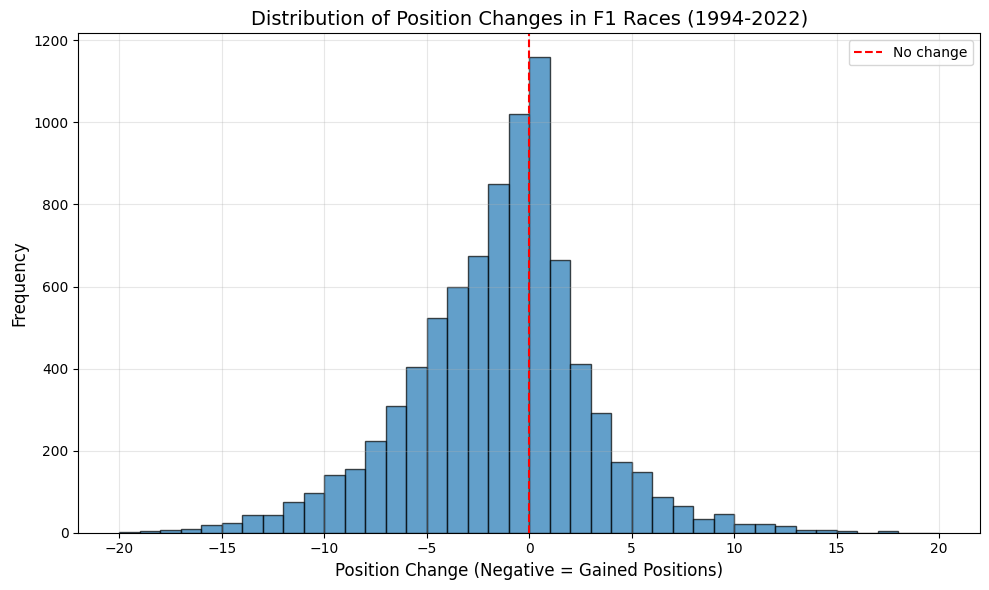

In [2]:
import matplotlib.pyplot as plt

# Create position change visualization
plt.figure(figsize=(10, 6))
plt.hist(df_clean['position_change'], bins=range(-20, 21), edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label='No change')
plt.xlabel('Position Change (Negative = Gained Positions)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Position Changes in F1 Races (1994-2022)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()